<span style="font-size: 24px; color: white;">Lab 7</span>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Определяем параметры стиля для черной темы
font_color = (1.0, 1.0, 1.0)
fig_color = (0.0, 0.0, 0.0)
subplot_color = (0.05, 0.05, 0.05)

line_color = (1.0, 1.0, 1.0)
gray_color = (0.5, 0.5, 0.5)
light_gray_color = (0.6, 0.6, 0.6)

point_color_1 = (0.25, 0.5, 1.0)
point_color_2 = (0.5, 0.75, 1.0)

lit_fontsize = 9
big_fontsize = 12
title_fontsize = 15

yellow_color = np.array([0.8, 0.8, 0.0])
green_color = np.array([0.25, 0.75, 0.25])
blue_color = np.array([0.0, 0.25, 1.0]) 
red_color = np.array([0.8, 0.0, 0.0])

skyblue_color = np.array([0.5, 0.75, 1.0])

# Мой стиль
black_style = {
    'axes.facecolor': subplot_color,              # Цвет фона осей
    'axes.edgecolor': font_color,                 # Цвет границ осей
    'axes.titlesize': title_fontsize,
    'axes.titleweight': 'bold',
    'axes.titlecolor': font_color,
    'axes.labelsize': title_fontsize,
    'axes.labelweight': 'bold',
    'axes.labelcolor': font_color,
    'axes.grid': True,                            # Включение сетки
    'grid.color': gray_color,                     # Цвет сетки
    'grid.alpha': 0.5,                            # Прозрачность сетки
    'xtick.color': font_color,                    # Цвет меток на оси x
    'ytick.color': font_color,                    # Цвет меток на оси y
    'figure.facecolor': fig_color,          # Цвет фона фигуры
    'figure.edgecolor': fig_color,          # Цвет границы фигуры
    'lines.linewidth': 2,
    'legend.fontsize': lit_fontsize,
    'legend.labelcolor': font_color,
    'legend.facecolor': fig_color, 
    'legend.edgecolor': fig_color,
}

# Применяем стиль
plt.style.use(black_style)

def grad_colors(n_colors, color_1, color_2):
    return [color_1 + (color_2 - color_1) * i / (n_colors - 1) for i in range(n_colors)]

1.

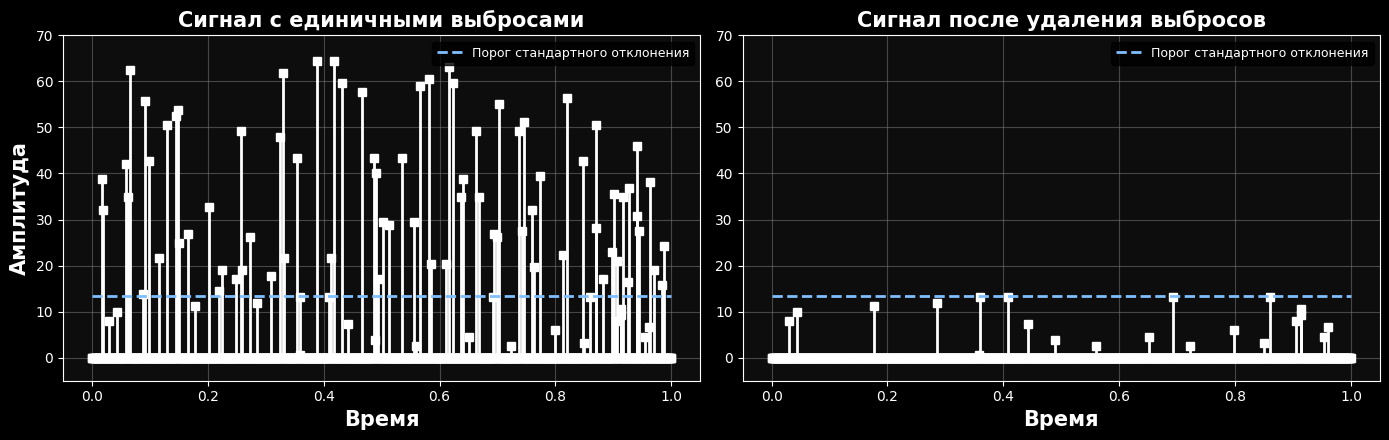

In [3]:
# Функция создания ровного сигнала с выбросами
def signal_with_outliers(a=0, b=1, num_outliers=10, max_amplitude_outliers=1, sampling_frequency=1000, amplitudes_variants=100):
    np.random.seed(215)
    t = np.linspace(a, b, sampling_frequency)
    signal_length = len(t)
    signal = np.zeros(signal_length)

    outlier_indices = np.random.choice(signal_length, size=num_outliers, replace=False)
    outlier_values = np.random.choice(np.linspace(0, max_amplitude_outliers, amplitudes_variants), size=num_outliers)
    signal[outlier_indices] = outlier_values
    
    return t, signal

def remove_outliers(signal, threshold=1):
    mean = np.mean(signal)
    standard_deviation = np.std(signal)
    
    upper_limit = mean + threshold * standard_deviation
    lower_limit = mean - threshold * standard_deviation

    filtered_signal = np.where((signal > upper_limit) | (signal < lower_limit), 0, signal)
    
    return filtered_signal, [lower_limit, upper_limit]


# Ровный сигнал с выбросами
a = 0
b = 1
num_outliers = 100
max_amplitude_outliers = 65
sampling_frequency = 1000
outliers_t, outliers_signal = signal_with_outliers(a=a, b=b, num_outliers=num_outliers, 
                                       max_amplitude_outliers=max_amplitude_outliers, sampling_frequency=sampling_frequency)

cleaned_outliers_signal, cleaned_outliers_signal_limits = remove_outliers(outliers_signal)


# Визуализация
plt.figure(figsize=(14, 4.5))
ylim_lt = -5
ylim_rt = max_amplitude_outliers + 5

plt.subplot(1, 2, 1)
plt.stem(outliers_t, outliers_signal, linefmt='w-', markerfmt='ws', basefmt='w-')
plt.plot([a, b], [cleaned_outliers_signal_limits[-1], cleaned_outliers_signal_limits[-1]], linestyle="--", color=skyblue_color,
         label="Порог стандартного отклонения")
plt.title("Сигнал с единичными выбросами")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.ylim(ylim_lt, ylim_rt)
plt.legend()

plt.subplot(1, 2, 2)
plt.stem(outliers_t, cleaned_outliers_signal, linefmt='w-', markerfmt='ws', basefmt='w-')
plt.plot([a, b], [cleaned_outliers_signal_limits[-1], cleaned_outliers_signal_limits[-1]], linestyle="--", color=skyblue_color,
         label="Порог стандартного отклонения")
plt.title("Сигнал после удаления выбросов")
plt.xlabel("Время")
plt.ylim(ylim_lt, ylim_rt)
plt.legend()

plt.tight_layout()
plt.show()


2.

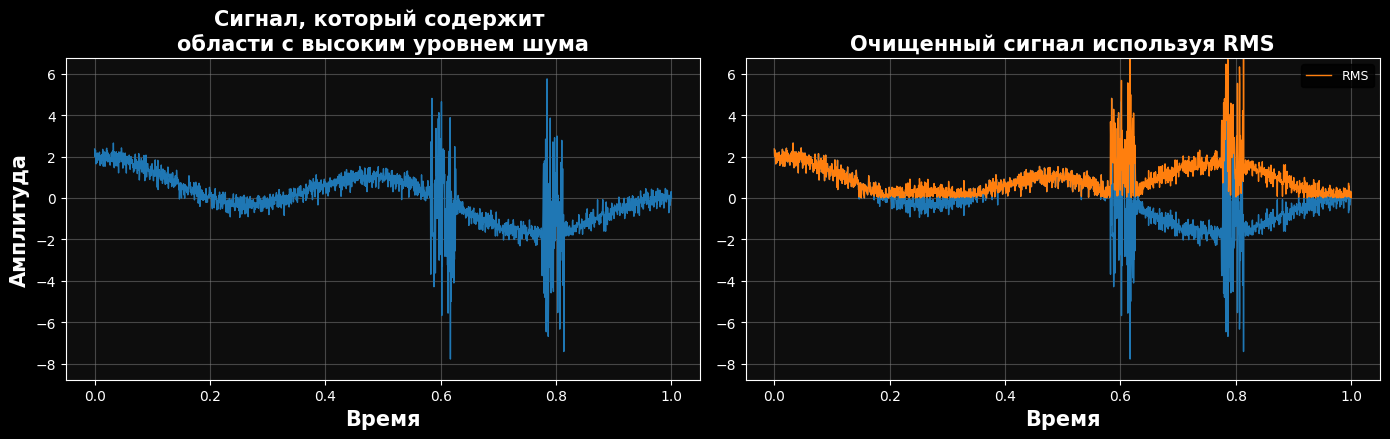

In [4]:
# Функция которая вычисляет скользящее RMS для сигнала.
def sliding_rms(signal, window_size):
  window = np.ones(window_size) / window_size                         # Окно среднего
  squared_signal = signal**2                                          # Возведение сигнала в квадрат
  rms = np.sqrt(np.convolve(squared_signal, window, mode='same'))     # Режим same для сохранения длины
  return rms

def clean_signal_with_rms(signal, window_size=50, threshold=1.0):
  rms = sliding_rms(signal, window_size)
  noisy_indices = rms > threshold
  cleaned_signal = signal.copy()

  for i in range(len(signal)):
    if noisy_indices[i]:                                      # Если текущий индекс - это шум
      start = max(0, i - window_size // 2)                    # Начало окна
      end = min(len(signal), i + window_size // 2 + 1)        # Конец окна
      window_values = signal[start:end]                       # Значения внутри окна
      cleaned_signal[i] = np.median(window_values)            # Заменяем на медиану окна
    

  return cleaned_signal, rms


def add_random_noise_regions(signal, amount_regions=2, max_amplitude=5.0, min_width=10, max_width=100):
  np.random.seed(215)

  new_signal = signal.copy()
  signal_length = len(signal)

  for _ in range(amount_regions):
    amplitude = np.random.uniform(0, max_amplitude)
    width = np.random.randint(min_width, max_width)
    start = np.random.randint(0, signal_length - width)

    new_signal[start:start+width] += amplitude * np.random.randn(width)

  return new_signal

# Временные характеристики
sampling_frequency = 2000
t = np.linspace(a, b, sampling_frequency)
hard_cos_f_list = np.fft.fftfreq(len(t), d=t[1] - t[0])

# Сигнал из суммы двух косинусов
f1 = 0.5
f2 = 2
signal = np.cos(2 * np.pi * f1 * t) + np.cos(2 * np.pi * f2 * t)

# Шум 
noise_amplitude = 0.25
noise = noise_amplitude * np.random.randn(sampling_frequency)
noisy_signal = signal + noise

big_noisy_signal = add_random_noise_regions(noisy_signal, max_amplitude=20)

# Очистка сигнала
threshold = 2.0
window_size = 1
cleaned_signal, rms = clean_signal_with_rms(big_noisy_signal, window_size=window_size, threshold=threshold)

# Визуализация
plt.figure(figsize=(14, 4.5))
ylim_lt = min(big_noisy_signal) - 1
ylim_rt = max(big_noisy_signal) + 1

plt.subplot(1, 2, 1)
plt.plot(t, big_noisy_signal, linewidth=1)
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Сигнал, который содержит \nобласти с высоким уровнем шума")
plt.ylim(ylim_lt, ylim_rt)

plt.subplot(1, 2, 2)
plt.plot(t, cleaned_signal, linewidth=1)
plt.plot(t, rms, linewidth=1, label="RMS")
plt.xlabel("Время")
plt.title("Очищенный сигнал используя RMS")
plt.ylim(ylim_lt, ylim_rt)
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

3.

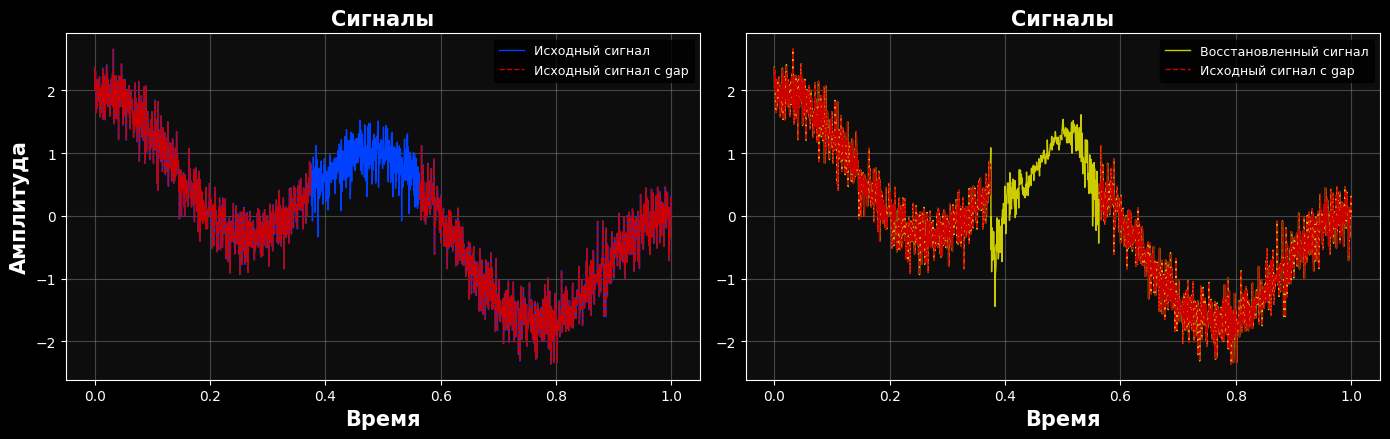

In [9]:
# 1. Создаем исходный сигнал
signal_3 = noisy_signal.copy()
signal_3_fft = np.fft.fft(signal_3)

# 2. Удаляем часть сигнала
gap_persent = 0.25                                      # Количество точек в соотношении от начальных станут gap

gap_norm = max(min(gap_persent, 1), 0)
gap_half_window = int(len(t) * gap_norm / 2)
gap_start = len(t) // 2 - gap_half_window               # Индексы начала gap
gap_end = len(t) // 2 + int(0.5 * gap_half_window)      # Индексы конца gap 
signal_with_gap = signal_3.copy()
signal_with_gap[gap_start:gap_end] = np.nan             # Обнуляем значения в удаленной части

# 3. Определяем окна для спектрального анализа
window_size = 600  # Длина окон слева и справа от разрыва

left_window = signal_with_gap[gap_start - window_size:gap_start]
right_window = signal_with_gap[gap_end:gap_end + window_size]

# 4. Вычисляем спектры левого и правого окон
fft_left = np.fft.fft(left_window)
fft_right = np.fft.fft(right_window)

# 5. Усредняем спектры

# Вариант A: без учета фазы
fft_avg = (fft_left + fft_right) / 2

# Вариант Б: c учетом фазы
fft_avg_amplitude = (np.abs(fft_left) + np.abs(fft_right)) / 2               # Усредняем только амплитуды
# fft_avg_phase = np.angle(fft_left)                                         # Фаза из левого окна: вариант 1
fft_original_phase = np.angle(np.fft.fft(signal_3[gap_start:gap_end]))       # Фаза исходного сигнала: вариант 2
fft_original_phase_resized = np.interp(np.linspace(0, len(fft_original_phase), len(fft_avg_amplitude)),
    np.arange(len(fft_original_phase)), fft_original_phase)                  # Подгоняем длину фазы к длине амплитуд
fft_avg = fft_avg_amplitude * np.exp(1j * fft_original_phase_resized)        # Восстанавливаем комплексный спектр

# 6. Восстанавливаем сигнал в утраченной области
reconstructed_gap = np.fft.ifft(fft_avg).real                                  # Обратное преобразование Фурье
reconstructed_gap = np.interp(np.arange(gap_end - gap_start), np.linspace(0, gap_end - gap_start, 
    len(reconstructed_gap)), reconstructed_gap)                                # Подгоняем длину восстановленного участка

# 7. Вставляем восстановленный сигнал
reconstructed_signal = signal_with_gap.copy()
reconstructed_signal[gap_start:gap_end] = reconstructed_gap


# Графики
plt.figure(figsize=(14, 4.5))

# Исходный сигнал
plt.subplot(1, 2, 1)
plt.plot(t, noisy_signal, label="Исходный сигнал", color=blue_color, linewidth=1)
plt.plot(t, signal_with_gap, label="Исходный сигнал с gap", linestyle="--", linewidth=1, color=red_color) # Сигнал с gap
plt.title("Сигналы")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()

# Восстановленный сигнал
plt.subplot(1, 2, 2)
plt.plot(t, reconstructed_signal, label="Восстановленный сигнал", linewidth=1, color=yellow_color)
plt.plot(t, signal_with_gap, label="Исходный сигнал с gap", linestyle="--", linewidth=1, color=red_color) # Сигнал с gap
plt.title("Сигналы")
plt.xlabel("Время")
plt.legend()

plt.tight_layout()
plt.show()



4.

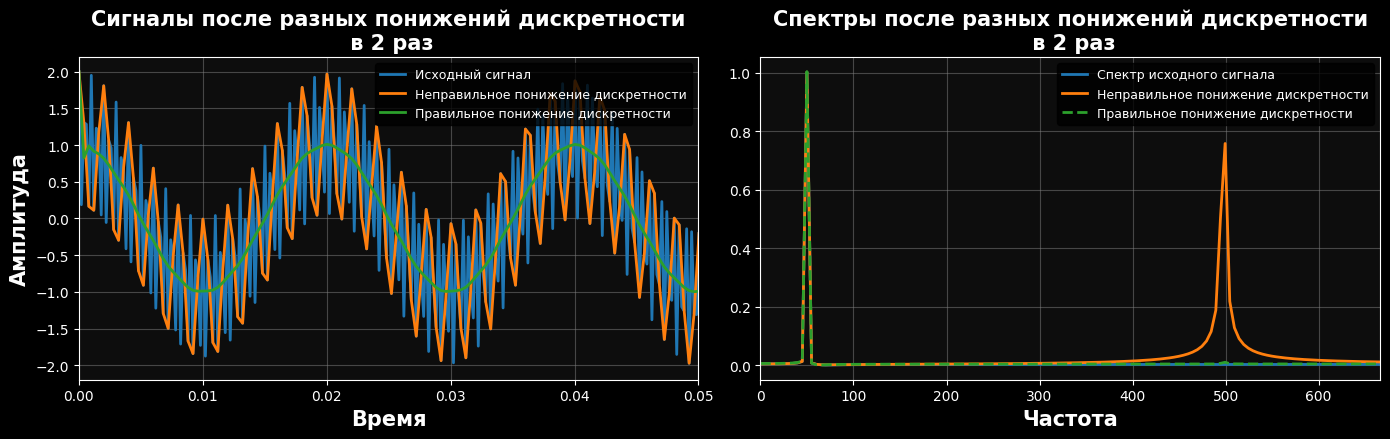

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Функция создания сложного cos сигнала
def create_hard_cos_signal(hard_cos_f_list, hard_cos_duration, hard_cos_sampling_frequency):
    t = np.linspace(0, hard_cos_duration, hard_cos_sampling_frequency)
    signal = sum(np.cos(2 * np.pi * f * t) for f in hard_cos_f_list)
    return t, signal


#Функция неправильного понижения дискретности (просто удаляем точки)
def downsample_incorrect(signal, factor, t):
    signal_downsampled = signal[::factor]
    t_downsampled = t[::factor]
    return t_downsampled, signal_downsampled

# Функция правильного понижения дискретности (с фильтрацией и удалением точек)
def downsample_correct(signal, factor, t, freq):
    
    # Функция фильтрации для предотвращения алиасинга
    def lowpass_filter(signal, fs, cutoff_freq):
        nyquist = 0.5 * fs                                  # Частота Найквиста
        normal_cutoff = cutoff_freq / nyquist               # Нормализованная частота среза
        b, a = butter(2, normal_cutoff, btype='low', analog=False)
        return filtfilt(b, a, signal)
    
    
    # Фильтруем сигнал перед понижением
    cutoff_freq = freq / (2 * factor)  # Частота среза для фильтрации
    signal_filtered = lowpass_filter(signal, freq, cutoff_freq)
    
    # Уменьшаем дискретность после фильтрации
    signal_downsampled = signal_filtered[::factor]
    
    # Создаем новые временные метки для пониженного сигнала
    t_downsampled = t[::factor]
    
    return t_downsampled, signal_downsampled


# Параметры исходного сигнала
hard_cos_f_list = [50, 2000]             # Частоты 50 Гц и 100 Гц
hard_cos_duration = 0.2                 # Продолжительность
hard_cos_sampling_frequency = 1000      # Исходная частота дискретизации

# Создание исходного сигнала
t_signal_4, signal_4 = create_hard_cos_signal(hard_cos_f_list, hard_cos_duration, hard_cos_sampling_frequency)
frequencies_signal_4 = np.fft.fftfreq(len(t_signal_4), d=t_signal_4[1] - t_signal_4[0])
signal_4_fft = np.fft.fft(signal_4)


# Понижение дискретности во столько-то раз
downsample_coeff = 2

# Неправильный способ (удаление точек)
t_incorrect, signal_incorrect = downsample_incorrect(signal_4, downsample_coeff, t_signal_4)
frequencies_incorrect = np.fft.fftfreq(len(t_incorrect), d=t_incorrect[1] - t_incorrect[0])
signal_incorrect_fft = np.fft.fft(signal_incorrect)

# Правильный способ (с фильтрацией и удалением точек)
t_correct, signal_correct = downsample_correct(signal_4, downsample_coeff, t_signal_4, hard_cos_sampling_frequency)
frequencies_correct = np.fft.fftfreq(len(t_correct), d=t_correct[1] - t_correct[0])
signal_correct_fft = np.fft.fft(signal_correct)

# Новая частота дискретизации после понижения
fs_new_incorrect = hard_cos_sampling_frequency // downsample_coeff
fs_new_correct = hard_cos_sampling_frequency // downsample_coeff


# График 2
# Неправильное понижение дискретности
plt.figure(figsize=(14, 4.5))

plt.subplot(1, 2, 1)
plt.plot(t_signal_4, signal_4, label="Исходный сигнал")
plt.plot(t_incorrect, signal_incorrect, label="Неправильное понижение дискретности")
plt.plot(t_correct, signal_correct, label="Правильное понижение дискретности")
plt.title(f"Сигналы после разных понижений дискретности\n в {downsample_coeff} раз")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend()
plt.xlim(0, 0.05)

plt.subplot(1, 2, 2)
plt.plot(frequencies_signal_4[:len(frequencies_signal_4)//2], np.abs(signal_4_fft[:len(signal_4_fft)//2]) * 2 / len(t_signal_4), 
         label="Cпектр исходного сигнала")
plt.plot(frequencies_incorrect[:len(frequencies_incorrect)//2], np.abs(signal_incorrect_fft[:len(signal_incorrect_fft)//2]) * 2 / len(t_incorrect), 
         label="Неправильное понижение дискретности")
plt.plot(frequencies_correct[:len(frequencies_correct)//2], np.abs(signal_correct_fft[:len(signal_correct_fft)//2]) * 2 / len(t_correct), 
         label="Правильное понижение дискретности", linestyle="--")
plt.xlim(0, len(t_signal_4)//1.5)
plt.title(f"Спектры после разных понижений дискретности\n в {downsample_coeff} раз")
plt.xlabel("Частота")
plt.legend()

plt.tight_layout()
plt.show()


5.

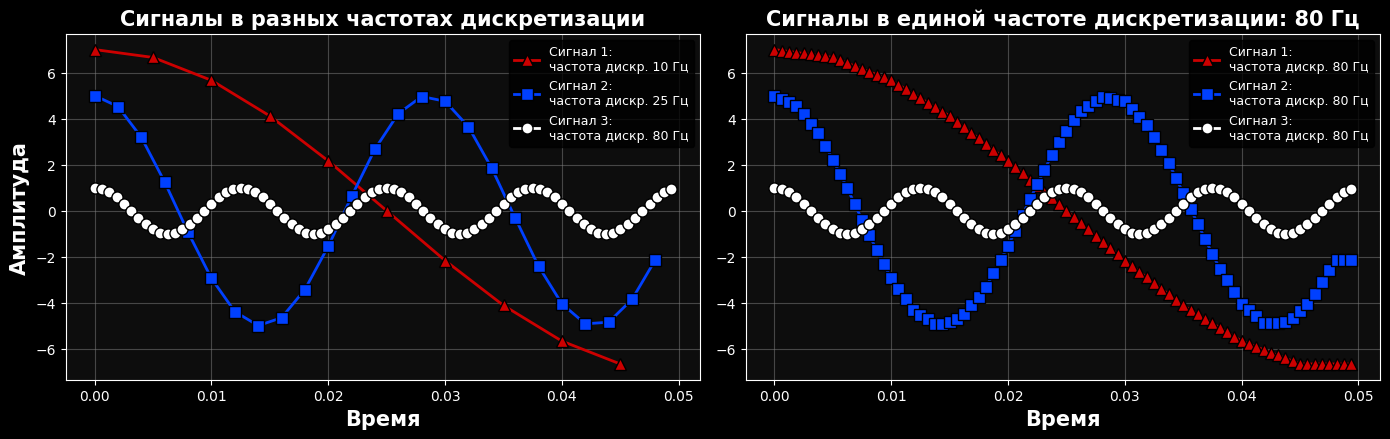

In [29]:
# Функция увеличения дескритезации
def upsample(signal, original_rate, target_rate):
    # Создаем временные оси для исходного и нового сигналов
    original_time = np.linspace(0, len(signal) / original_rate, len(signal), endpoint=False)
    target_time = np.linspace(0, len(signal) / original_rate, int(len(signal) * target_rate / original_rate), endpoint=False)
    
    # Выполняем интерполяцию
    resampled_signal = np.interp(target_time, original_time, signal)
    return resampled_signal

# Исходные параметры сигналов
freq_1, freq_2, freq_3 = 10, 35, 80 
sampling_freq_1, sampling_freq_2, sampling_freq_3 = 10, 25, 80
ampl_1, ampl_2, ampl_3 = 7, 5, 1

duration = 0.05

# Генерация сигналов
t_1 = np.linspace(0, duration, sampling_freq_1, endpoint=False)
t_2 = np.linspace(0, duration, sampling_freq_2, endpoint=False)
t_3 = np.linspace(0, duration, sampling_freq_3, endpoint=False)

signal1 = ampl_1 * np.cos(2 * np.pi * freq_1 * t_1)
signal2 = ampl_2 * np.cos(2 * np.pi * freq_2 * t_2)
signal3 = ampl_3 * np.cos(2 * np.pi * freq_3 * t_3)

# Находим максимальную частоту дискретизации
target_sampling_rate = max(sampling_freq_1, sampling_freq_2, sampling_freq_3)

# Приведение сигналов к общей частоте дискретизации
resampled_signal1 = upsample(signal1, sampling_freq_1, target_sampling_rate)
resampled_signal2 = upsample(signal2, sampling_freq_2, target_sampling_rate)
resampled_signal3 = upsample(signal3, sampling_freq_3, target_sampling_rate)

# Временная ось для целевой частоты дискретизации
t_target = np.linspace(0, duration, target_sampling_rate, endpoint=False)

# Графики
plt.figure(figsize=(14, 4.5))

# Оригинальные сигналы
plt.subplot(1, 2, 1)
plt.plot(t_1, signal1, label=f"Сигнал 1:\nчастота дискр. {sampling_freq_1} Гц", 
         marker='^', markeredgecolor=fig_color, markersize=8, color=red_color)
plt.plot(t_2, signal2, label=f"Сигнал 2:\nчастота дискр. {sampling_freq_2} Гц", 
         marker='s', markeredgecolor=fig_color, markersize=8, color=blue_color)
plt.plot(t_3, signal3, label=f"Сигнал 3:\nчастота дискр. {sampling_freq_3} Гц", 
         marker='o', markeredgecolor=fig_color, markersize=8, color=font_color)
plt.title(f"Сигналы в разных частотах дискретизации")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.legend(loc='upper right')

# Приведенные к единой частоте дискретизации сигналы
plt.subplot(1, 2, 2)
plt.plot(t_target, resampled_signal1, label=f"Сигнал 1:\nчастота дискр. {target_sampling_rate} Гц", 
         marker='^', markeredgecolor=fig_color, markersize=8, color=red_color)
plt.plot(t_target, resampled_signal2, label=f"Сигнал 2:\nчастота дискр. {target_sampling_rate} Гц", 
         marker='s', markeredgecolor=fig_color, markersize=8, color=blue_color)
plt.plot(t_target, resampled_signal3, label=f"Сигнал 3:\nчастота дискр. {target_sampling_rate} Гц", 
         marker='o', markeredgecolor=fig_color, markersize=8, color=font_color)
plt.title(f"Сигналы в единой частоте дискретизации: {target_sampling_rate} Гц")
plt.xlabel("Время")
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
